<a href="https://colab.research.google.com/github/akiraparrus/akiraparrus/blob/main/Data_Analysis_and_Model_Development_for_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd

df= pd.read_csv('/content/ds_salaries.csv');
df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [19]:
df.columns # Checking the column names to know which variables are present

Index(['Unnamed: 0', 'work_year', 'experience_level', 'employment_type',
       'job_title', 'salary', 'salary_currency', 'salary_in_usd',
       'employee_residence', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

In [23]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

In [21]:
df.isnull().sum()  # Check for missing values

,0
Unnamed: 0,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0


In [22]:
df = df.dropna()  # Drop missing values

In [4]:
df = pd.get_dummies(df, drop_first=True)  # Convert categorical variables to dummy/indicator variables

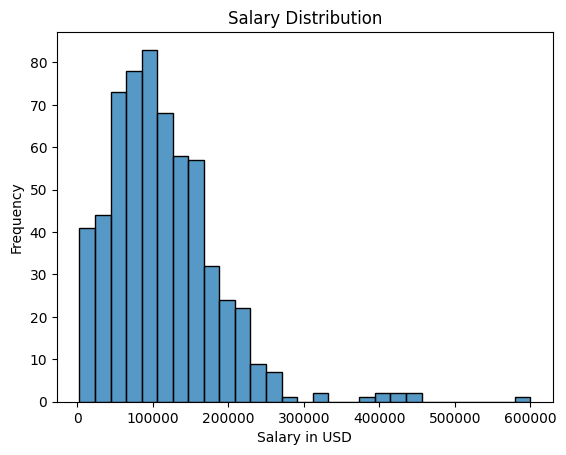

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot salary distribution
sns.histplot(df['salary_in_usd'])
plt.title('Salary Distribution')
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.show()

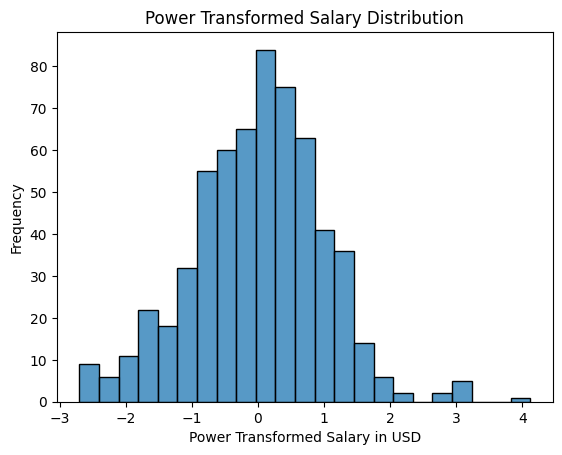

In [25]:
from sklearn.preprocessing import PowerTransformer

# Initialize the PowerTransformer (which includes Box-Cox)
transformer = PowerTransformer(method='box-cox')  # Make sure all values are > 0

# Apply the transformation to salary_in_usd
df['power_transformed_salary'] = transformer.fit_transform(df[['salary_in_usd']])

# Check the new distribution
sns.histplot(df['power_transformed_salary'])
plt.title('Power Transformed Salary Distribution')
plt.xlabel('Power Transformed Salary in USD')
plt.ylabel('Frequency')
plt.show()


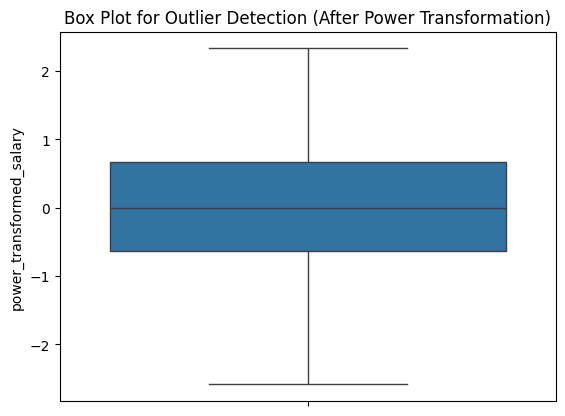

In [26]:
# Check for outliers using IQR
Q1 = df['power_transformed_salary'].quantile(0.25)
Q3 = df['power_transformed_salary'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_no_outliers = df[(df['power_transformed_salary'] >= lower_bound) & (df['power_transformed_salary'] <= upper_bound)]

# Visualize with box plot
sns.boxplot(df_no_outliers['power_transformed_salary'])
plt.title('Box Plot for Outlier Detection (After Power Transformation)')
plt.show()

Feature Engineering

In [27]:
# Example: Bin the salary into categories
bins = [0, 50000, 100000, 150000, 200000, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High', 'Extreme']
df['salary_binned'] = pd.cut(df['salary_in_usd'], bins=bins, labels=labels)

In [29]:
from sklearn.model_selection import train_test_split

# Define the features (X) and target (y)
X = df_encoded.drop(columns=['salary_in_usd'])
y = df_encoded['salary_in_usd']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(485, 186) (122, 186) (485,) (122,)


In [32]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # alpha is the regularization parameter

# Fit the model
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Mean Squared Error: {mse_ridge}")
print(f"R-squared: {r2_ridge}")


Mean Squared Error: 340099937.34473616
R-squared: 0.9112605874348954


API

In [34]:
!pip install fastapi uvicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.3 MB/s eta 0:00:00


In [35]:
%%writefile main.py
import pandas as pd
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import uvicorn

# Initialize FastAPI
app = FastAPI()

# Define the request body format for predictions
class PredictionFeatures(BaseModel):
    experience_level_encoded: float
    company_size_encoded: float
    employment_type_PT: int
    job_title_Data_Engineer: int
    job_title_Data_Manager: int
    job_title_Data_Scientist: int
    job_title_Machine_Learning_Engineer: int

# Global variable to store the loaded model
model = None

# Download the model
def download_model():
    global model
    model = joblib.load('/content/lin_regress.sav')  # Make sure the model is uploaded

# Download the model immediately when the script runs
download_model()

# API Root endpoint
@app.get("/")
async def index():
    return {"message": "Welcome to the Data Science Income API. Use the /predict feature to predict your income."}

# Prediction endpoint
@app.post("/predict")
async def predict(features: PredictionFeatures):

    # Create input DataFrame for prediction
    input_data = pd.DataFrame([{
        "experience_level_encoded": features.experience_level_encoded,
        "company_size_encoded": features.company_size_encoded,
        "employment_type_PT": features.employment_type_PT,
        "job_title_Data Engineer": features.job_title_Data_Engineer,
        "job_title_Data Manager": features.job_title_Data_Manager,
        "job_title_Data Scientist": features.job_title_Data_Scientist,
        "job_title_Machine Learning Engineer": features.job_title_Machine_Learning_Engineer
    }])

    # Predict using the loaded model
    prediction = model.predict(input_data)[0]

    return {
        "Salary (USD)": prediction
    }

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)


Writing main.py
